# k-means-u and k-means-u* - empirical results
systematic experiments with different data sets and ranges of $k$

## read simulation results from file (default) or simulate yourself?
Set to the variable below to true to simulate yourself, but be patient (simulations in this notebook took over 12 hours on a relatively recent PC)

In [1]:
simulate=False # if this is set to False (recommended), the simulation results are read from pickle files

In [2]:
#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
imgdir=os.path.join('img')
datadir=os.path.join('..','data')
libdir=os.path.join('..','lib')
pkldir=os.path.join('..','pickle')
module_path = os.path.abspath(libdir)
if module_path not in sys.path:
    sys.path.append(module_path)


In [4]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import bottleneck as bn
import copy
import math
import random
from bfdataset import dataset
from bfutil import finish, whoami, dplot, dplot1
from sklearn.preprocessing import StandardScaler
from kmeansu import kmeansU

In [5]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

## set fontsize for plots

In [6]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# Input Data Sets

## 2D grid data (data set A)

In [7]:
def getAData():
    D = dataset.grid(so=6,si=6,grid1=1,grid2=1)
    print(D.n)
    return D.getData()
#fig=dplot(getAData(),ticks=False,size=10,ms=4.5)
#fig.savefig("img/paperdata.png",bbox_inches='tight', dpi=300)


<img src="img/paperdata.png" alt="Drawing" style="width: 500px;" align="left"/>

## 2D data without clusters (data set B)

In [8]:
def getFlatData():
    D = dataset.grid(so=1,si=36,grid1=1,grid2=1)
    
    print(D.n)
    return D.getData()
#np.savetxt('data/flatdata.txt', getFlatData(), delimiter=' ')
#fig=dplot(getFlatData(),ticks=False,size=10,ms=4.5)
#fig.savefig("img/flatdata.png",bbox_inches='tight', dpi=300)


<img src="img/flatdata.png" style="width: 500px;" align="left">

# 5D gaussian data 

In [9]:
def fig_gaussiandata():
    D=dataset.gaussmixXD(n=2000,d=5,g=50,sig=0.0001)
    a=D.getData()
    fig=dplot(a,ticks=False,size=20)
    return fig, a
def read5DgaussianData():
    a = pd.read_csv(os.path.join(datadir,"5Dgaussiandata.txt"),sep='\s+', engine='python', header=None)
    a = a.as_matrix()
    #print(a)
    fig=dplot(a,ticks=False,size=20)
    return fig,a
#figg, a5 = read5DgaussianData();
#figg, a5 = fig_gaussiandata()
#np.savetxt('data/5Dgaussiandata.txt', a5, delimiter=' ')
#figg.savefig("img/gaussian5D",bbox_inches='tight', dpi=100)


<img src="img/gaussian5D.png" alt="Drawing" align="left"/>

## Cloud Data
https://archive.ics.uci.edu/ml/datasets/Cloud
* n = 1024
* d = 10

In [10]:
def readCloudData():
    newdata = pd.read_csv(os.path.join(datadir,"cloud1.txt"),sep='\s+', engine='python', header=None)
    sdata= StandardScaler().fit_transform(newdata)
    #print(newdata.describe())
    return sdata
#fig = dplot(readCloudData(),ticks=False);
#fig.savefig("img/clouddata_low.png",bbox_inches='tight', dpi=100)

<img src="img/clouddata_low.png" alt="Drawing" align="left"/>

## Propulsion Data
https://archive.ics.uci.edu/ml/datasets/Condition+Based+Maintenance+of+Naval+Propulsion+Plants#
* n=11934
* d=16

In [11]:
def readPropulsionData():
    newdata = pd.read_csv(os.path.join(datadir,"propulsiondata.txt"),sep='\s+', engine='python', header=None)
    sdata= StandardScaler().fit_transform(newdata)
    return sdata[:,:-2] # last two columns are steering parameters which are set instead of measured
#fig=dplot(readPropulsionData(),ticks=False)
#fig.savefig("img/propulsiondata_low.png",bbox_inches='tight', dpi=100)

<img src="img/propulsiondata_low.png" alt="Drawing" align="left"/>

## Main Simulation Loop
perform a number of simulation for different values of k

* X: data set
* sizes: k-values to simulate
* runsPerModel: How often to run with one k-value and one model
* n_init: Repeat-Parameter for k-means++
* table: Print out table?
* maxRetry: parameter or k-means-u*
### Returns: dictionary of pandas dataFrames, one for each $k$-value


In [12]:
import time
from collections import Counter
def simu(X,sizes, runsPerModel, n_init=10, table=True,maxRetry=2):
    #print("simu(): X=",X)
    #phase0: initialization and normal k-means
    #phase1: improvement with k-means-u
    n0={} # no of Lloyd iterations k-means
    nz={} # no of Lloyd iterations k-means-u
    n1={} # no of Lloyd iterations k-means-u*
    nu={} # no of k-means-u(*) jumps
    e0={} # k-means error
    e1={} # k-means-u error
    e2={} # k-means-u* error
    t0={} # k-means time
    t1={} # k-means-u(*) time
    td={} # %delta time of k-means-u
    C0={} # k-means codebook
    C1={} # k-means-u codebook
    imp = {} # improvement obtained through k-means-u
    impr = {} # improvement obtained through k-means-u*
    nimp = {} # no of improvements
    
    d={} # dict of dataframes, contains statistics of all runs for a value of k
    e={} # contains statistics for all values of k
    # create a pandas dataFrame for each size
    for s in sizes:
        d[str(s)]=pd.DataFrame()
    # k-values
    for k in sizes:
        # seeding methods
        for init,shrt in [("k-means++","km++"),("random","rnd")][:1]:
            #print(init, end=': ')
            n0[init]=[] 
            nz[init]=[] 
            n1[init]=[] 
            nu[init]=[] 
            e0[init]=[] 
            e1[init]=[] 
            e2[init]=[] 
            t0[init]=[] 
            t1[init]=[] 
            td[init]=[] 
            C0[init]=[] 
            C1[init]=[] 
            imp[init]=[]  
            impr[init]=[] 
            nimp[init]=[] 
            for j in range(runsPerModel):

                T0 = time.time()
                kmeans = KMeans(n_clusters=k, init=init, n_init=n_init) # initial run with kmeans++, only one run 
                kmeans.fit(X) # actually compute k-means clustering
                T1= time.time()
                #print(T0,T1,T1-T0)
                Corig = copy.deepcopy(kmeans.cluster_centers_) # remember the k-means result
                C0[init].append(copy.deepcopy(kmeans.cluster_centers_)) # store k-means result
                # initial error from kmeans++
                err0 = 0+kmeans.inertia_
                # estimated number of Lloyd iterations used by k-means++:
                # (iterations of best run) * n_init
                n0[init].append(kmeans.n_iter_*n_init)

                kmeans = kmeansU(X,kmeans,maxRetry=maxRetry,loud=0) # kmeansU
                Cfinal=copy.deepcopy(kmeans.cluster_centers_) # remember the k-means result
                err1 = kmeans.noRetryErr
                err2 = kmeans.inertia_
                #print("err1 {} err2 {}\n".format(err1,err2))
                #print(dir(kmeans))
                #print ("err0:",err0,"err1:", err1, "Impro" if err1<err0 else "no impro")
                nz[init].append(kmeans.n_iter_u0) # Loyd iterations used by k-means-U
                n1[init].append(kmeans.n_iter_un) # Loyd iterations used by k-means-U*
                nu[init].append(kmeans.uruns) # number of non-local jumps

                T2=time.time()
                C1[init].append(copy.deepcopy(kmeans.cluster_centers_)) # store k-means++ result
                if (err2 < err1):
                    # additional improvement by k-means-u*
                    print("*", end='')
                    nimp[init].append(1)
                elif (err1 < err0):
                    # improvement by k-means-u
                    print("+", end='')
                    nimp[init].append(1)
                else:
                    # no improvement
                    print("-", end='')
                    nimp[init].append(0)

                t0[init].append(T1-T0) # time for k-means
                t1[init].append(T2-T1) # time for k-means-u (unoptimized)
                if (T1-T0 > 0):
                    td[init].append(((T2-T0)/(T1-T0)-1.0)) # relative addition of time due to k-means-u
                else:
                    td[init].append(0)

                e0[init].append(err0)  # k-means error
                e1[init].append(err1)  # k-means-u error
                e2[init].append(err2)  # k-means-u* error
                imp[init].append(1.-err1/err0) # improvement obtained through k-means-u
                impr[init].append(1.-err2/err0) # improvement obtained through k-means-u*
            d[str(k)]["n0["+shrt+"]"]=pd.Series(n0[init])
            d[str(k)]["nz["+shrt+"]"]=pd.Series(nz[init])
            d[str(k)]["n1["+shrt+"]"]=pd.Series(n1[init])
            d[str(k)]["nu["+shrt+"]"]=pd.Series(nu[init])
            d[str(k)]["e0["+shrt+"]"]=pd.Series(e0[init])
            d[str(k)]["e1["+shrt+"]"]=pd.Series(e1[init])
            d[str(k)]["e2["+shrt+"]"]=pd.Series(e2[init])
            d[str(k)]["t0["+shrt+"]"]=pd.Series(t0[init])
            d[str(k)]["t1["+shrt+"]"]=pd.Series(t1[init])
            d[str(k)]["td["+shrt+"]"]=pd.Series(td[init])
            d[str(k)]["imp["+shrt+"]"]=pd.Series(imp[init])
            d[str(k)]["impr["+shrt+"]"]=pd.Series(impr[init])
            d[str(k)]["nimp["+shrt+"]"]=pd.Series(nimp[init])
        print("  runsPerModel = ",runsPerModel, "noOfCenters:",k)
        # get important values from the descriobe() result
        ee = np.round(d[str(k)].describe().loc[["mean","std","min","max"]], decimals=4)
        e[k]=ee # store evaluation matrix for current k
        if table:
            from IPython.core.display import display, HTML
            output = ee.filter(regex=(".*km.*")).to_html(formatters={
                'nimp[km++]': '{:,.2%}'.format,
                'nimp[rnd]': '{:,.2%}'.format,
                'imp[km++]': '{:,.2%}'.format,
                'imp[rnd]': '{:,.2%}'.format,
                'td[km++]': '{:,.2%}'.format,
                'td[rnd]': '{:,.2%}'.format,
            })
            display(HTML(output))
    return e

## function for grid drawing

In [13]:
def dogrid(ax)   :
    ax.grid(True)
    ticklines = ax.get_xticklines() + ax.get_yticklines()
    gridlines = ax.get_xgridlines() + ax.get_ygridlines()
    #ticklabels = ax.get_xticklabels() + ax.get_yticklabels()

    for line in ticklines:
        line.set_linewidth(3)

    for line in gridlines:
        line.set_linestyle('-.')


## standard 3-part statistics for given dataset

In [14]:
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
def myfunc(y, pos=0):
    return '%1.1f%%'%(100*y)

#def statistics(e,size=(20,10),axdim=(2,1),ms=15,tick_spacing_y1=None, ticks_x=None):
def statistics(e,size=(20,11),axdim=(3,1),ms=15,tick_spacing_y1=None, ticks_x=None):
#def statistics(e,size=(20,5),axdim=(1,1),ms=15,tick_spacing_y1=None, ticks_x=None):
    # mak up to 3 plots of relevant statistical information:
    # improvement over k
    # fraction of improved solutions over k
    # computational overhead over k (how exactly measured?)
    kstar=1
    sizes = sorted(e.keys())
    
    # improvement of k-means-u over k-means++
    mean_imp = np.array([e[x].loc["mean","imp[km++]"]  for x in sizes])
    mean_impr = np.array([e[x].loc["mean","impr[km++]"]  for x in sizes])
    #print("mean:impr",mean_impr)
    #print("mean:imp",mean_imp)
    
    max_imp = np.array([e[x].loc["max","imp[km++]"]   for x in sizes])
    max_impr = np.array([e[x].loc["max","impr[km++]"]   for x in sizes])
    min_imp = np.array([e[x].loc["min","imp[km++]"]   for x in sizes])
    min_impr = np.array([e[x].loc["min","impr[km++]"]   for x in sizes])
    std_imp = np.array([e[x].loc["std","imp[km++]"]   for x in sizes])
    #print("mean",mean_imp)
    
    mean_nimp = [e[x].loc["mean","nimp[km++]"] for x in sizes]
    mean_n0  = [e[x].loc["mean","n0[km++]"]   for x in sizes]
    mean_nz  = [e[x].loc["mean","nz[km++]"]   for x in sizes]
    #print("mean:nz",np.array(mean_nz)/np.array(mean_n0))
    mean_n1  = [e[x].loc["mean","n1[km++]"]   for x in sizes]
    #print("mean:n1",np.array(mean_n1)/np.array(mean_n0))
    mean_e0  = [e[x].loc["mean","e0[km++]"]   for x in sizes]
    mean_e1  = [e[x].loc["mean","e1[km++]"]   for x in sizes]
    #print("meann",mean_nimp)

    fig,axs = plt.subplots(*axdim)
    fig.set_size_inches(*size)
    if axdim == (1,1):
        axs=[axs]
    ##
    ## Improvement
    ##
    ax=axs[0]
    #ax.plot(sizes,max_imp,"ro-",label="max improvement")
    #ax.set_ylim([0, 0.15])
    mini = np.min(sizes)
    maxi = np.max(sizes)
    #print(mini," - " , maxi, maxi-mini)
    if kstar:
        off = (maxi-mini)/800.0
        ax.errorbar(np.array(sizes)+off,mean_impr,yerr=[mean_impr-min_impr,
                    max_impr-mean_impr],capsize=4,fmt="ro-",linewidth=3,elinewidth=1,label='k-means-u*')
        ax.errorbar(np.array(sizes)-off,mean_imp,yerr=[mean_imp-min_imp,
                    max_imp-mean_imp],capsize=4,fmt="o-",linewidth=3,elinewidth=1,label='k-means-u')
    else:
        ax.errorbar(np.array(sizes),mean_imp,yerr=[mean_imp-min_imp,max_imp-mean_imp],
                    capsize=4,fmt="o-",linewidth=3,elinewidth=1)
        
    #ax.plot(np.array(sizes),mean_impr,"ro-",zorder=10)
    if kstar:
        #if dataname 
        ax.set_title("SSE reduction of k-means-u/k-means-u* over k-means++")
        #ax.set_title("SSE reduction of k-means-u and k-means-u* over k-means++")
    else:
        ax.set_title("SSE reduction of k-means-u over k-means++")
    #tick_spacing = 0.025
    if tick_spacing_y1 is not None:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y1))
    if ticks_x is not None:
        ax.xaxis.set_ticks(ticks_x)
    if 1:
        dogrid(ax)
        #ax.legend()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        ax.set_xlabel('$k$')
        ax.set_ylabel('SSE reduction')
        
        ttl = ax.title
        ttl.set_position([.5, 1.03])

    ax.yaxis.set_major_formatter(FuncFormatter(myfunc))

    if axdim == (3,1):
        ##
        ## Fraction Improvement
        ##
        ax=axs[2]
        ax.set_ylim([0, 1.1])
        ax.plot(sizes,mean_nimp,"r.-",ms=ms)
        ax.set_title("fraction of k-means++ solutions improved by k-means-u*")
        dogrid(ax)

        # manipulate axis to show percent
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in vals])
        #ax.set_ylim(0,1)
        ttl = ax.title
        ttl.set_position([.5, 1.03])
        
        ##
        ## Computation
        ##
        ax=axs[1]
        ax.plot(sizes,np.array(mean_n1)/np.array(mean_n0),"r.-",ms=ms,label='k-means-u*')
        #print(np.array(mean_n1)/np.array(mean_n0))
        ax.plot(sizes,np.array(mean_nz)/np.array(mean_n0),".-",ms=ms,label='k-means-u')
        #print(np.array(mean_nz)/np.array(mean_n0))
        ax.set_title("additional Lloyd iterations needed by kmeans-u/k-means-u* (relative to k-means++)")
        dogrid(ax)
        #if tick_spacing_y1 is not None:
        #    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y1))
        if ticks_x is not None:
            ax.xaxis.set_ticks(ticks_x)
        ax.set_xlabel('$k$')
        ax.set_ylabel('add. Lloyd iterations %')
        if 1:
            # legend
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels)
            # manipulate axis to show percent
            vals = ax.get_yticks()
            ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in vals])
            #ax.set_ylim(bottom=0) # do not use this !!!!!
            #ax.set_xlabel('$k$')
        if 0:
            if ticks_x is not None:
                ax.xaxis.set_ticks(ticks_x)
            ttl = ax.title
            ttl.set_position([.5, 1.03])

    if False:
        ax=axs[3]
        ax.semilogy(sizes,mean_e0,"o-")
        ax.semilogy(sizes,mean_e1,"o-")
        ax.set_title("error")
    plt.subplots_adjust(wspace=4.03, hspace=0.5)

    return fig

## parameters to steer the mass simulations

In [15]:
table=0 # if 1 (or True) write out a statistics table for each k-value
full=0 # if True or 1, use a large $k$-range
write=0 # write out figures to disk?
suffix="ZZZ" # added to generated png files
runsPerModel=10 # for each calue of $k$ that manu runs are performed
persist=0 # write out simulation results to file for later reuse


## data set $A$ simulation

In [16]:

if full:
    s = list(range(6*6*0+6,6*6*12+6*6,6))
else:
    s = list([6,12,18, 24,40,80])
#print (s)
X = getAData()


1296


In [17]:
if simulate:
    res1=simu(X,sizes=s,runsPerModel=runsPerModel, table=table,maxRetry=2)
else:
    print("reading simulation result from file ......")
    res1=pd.read_pickle(os.path.join(pkldir,"res1_0623.pickle"))    


reading simulation result from file ......


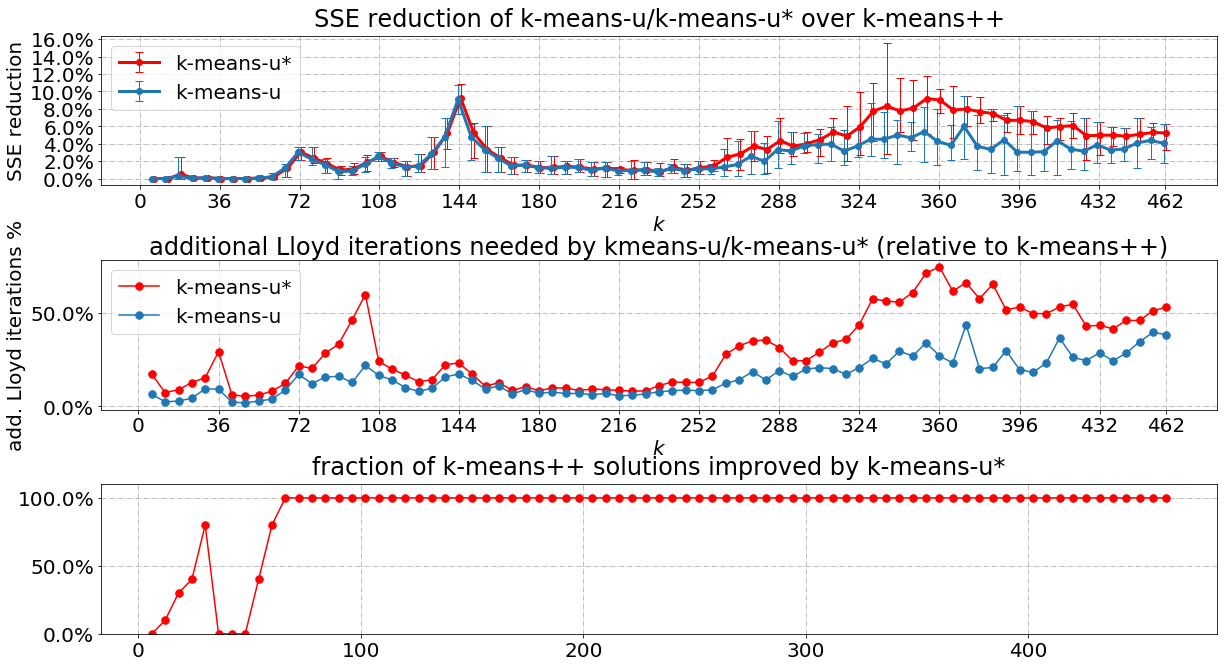

In [18]:
if simulate:
    ticks_x=None
else:
    ticks_x=np.concatenate((np.array([0]),np.arange(36, 13*36, 36),np.array([462])))
    #print(ticks_x)
fig1 = statistics(res1, tick_spacing_y1=0.02, ticks_x=ticks_x)#,size=(20,16))
#fig1 = statistics(res1, tick_spacing_y1=0.02)#,size=(20,16))

#fig = statistics(res1)
if write:
    fig1.savefig(os.path.join(imgdir,"gaussian2Dstat"+suffix+".png"),bbox_inches='tight', dpi=300)

## FlatData simulation

In [19]:

if full:
    s = list(range(6*6*0+6,6*6*12+6*6,6))
else:
    s = list([6,12,18, 24,40,80])
#print (s)
X = getFlatData()


1296


In [20]:
if simulate:
    res1a=simu(X,sizes=s,runsPerModel=runsPerModel, table=table,maxRetry=2)
else:
    print("reading simulation result from file ......")
    res1a=pd.read_pickle(os.path.join(pkldir,"res1a_0623.pickle") )   

reading simulation result from file ......


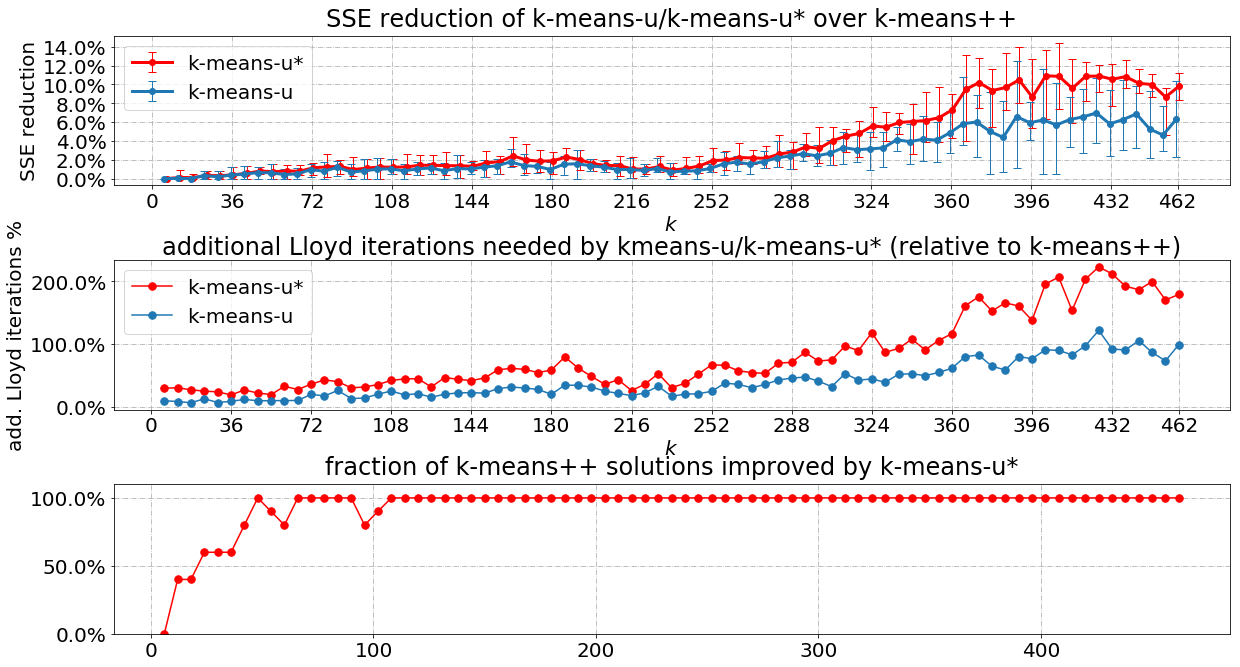

In [21]:
if simulate:
    ticks_x=None
else:
    ticks_x=np.concatenate((np.array([0]),np.arange(36, 13*36, 36),np.array([462])))
    #print(ticks_x)
fig1a = statistics(res1a, tick_spacing_y1=0.02, ticks_x=ticks_x)#,size=(20,16))

if write:
    fig1a.savefig(os.path.join(imgdir,"flat2Dstat"+suffix+".png"),bbox_inches='tight', dpi=300)

## 5D Gaussian simulation

In [22]:
D=dataset.gaussmixXD(n=2000,d=5,g=50,sig=0.00001)
X=D.getData()
if full:
    s = list(range(10,500,10))+list(range(500,2020,20))
else:
    s = list(range(10,50,10))
    

In [23]:
if simulate:
    res2=simu(X,sizes=s,runsPerModel=runsPerModel, table=table, maxRetry=2)
else:
    res2=pd.read_pickle(os.path.join(pkldir,"res2_0623.pickle"))    
    print("reading simulation result from file ......")
    

reading simulation result from file ......


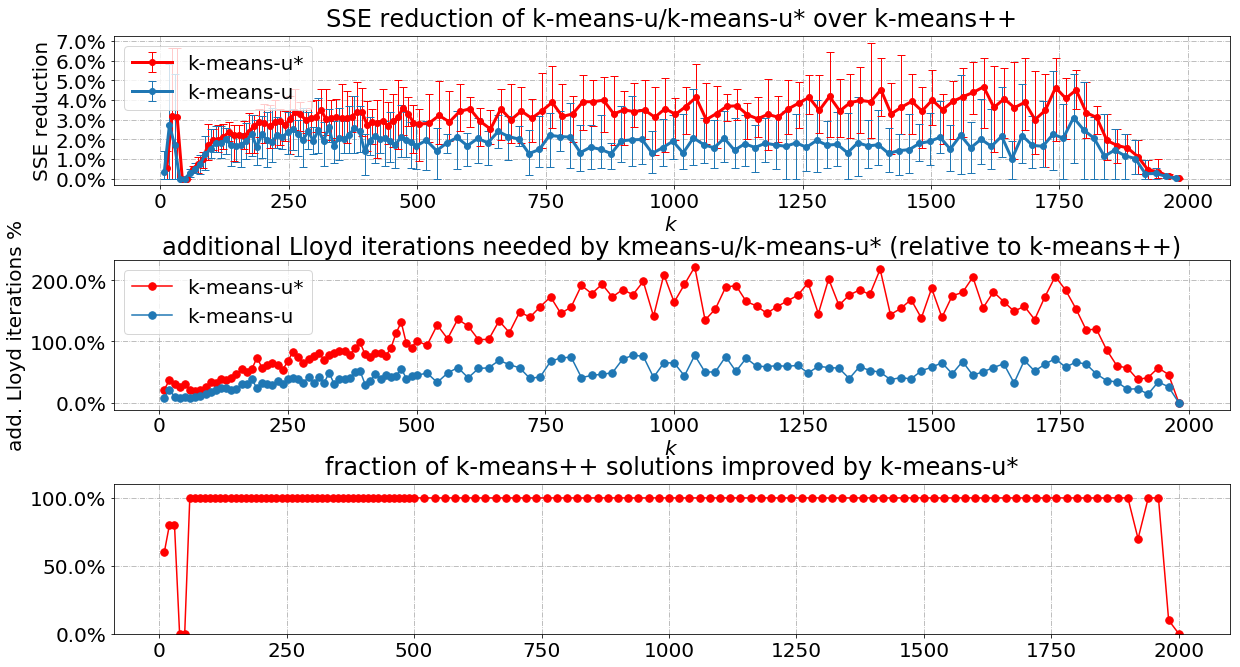

In [24]:
fig2 = statistics(res2, tick_spacing_y1=0.01)
if write:
    fig2.savefig(os.path.join(imgdir,"gaussian5Dstat"+suffix+".png"),bbox_inches='tight', dpi=300)

## Cloud Data Simulation

In [25]:
if simulate:
    X = readCloudData()
    if full:
        s = list(range(10,1010,20))+[1024]
    else:
        s = list(range(10,40,10))
    res3=simu(X,sizes=s,runsPerModel=runsPerModel, table=table, maxRetry=2)
else:
    print("reading simulation result from file ......")
    res3=pd.read_pickle(os.path.join(pkldir,"res3_0623.pickle"))    

reading simulation result from file ......


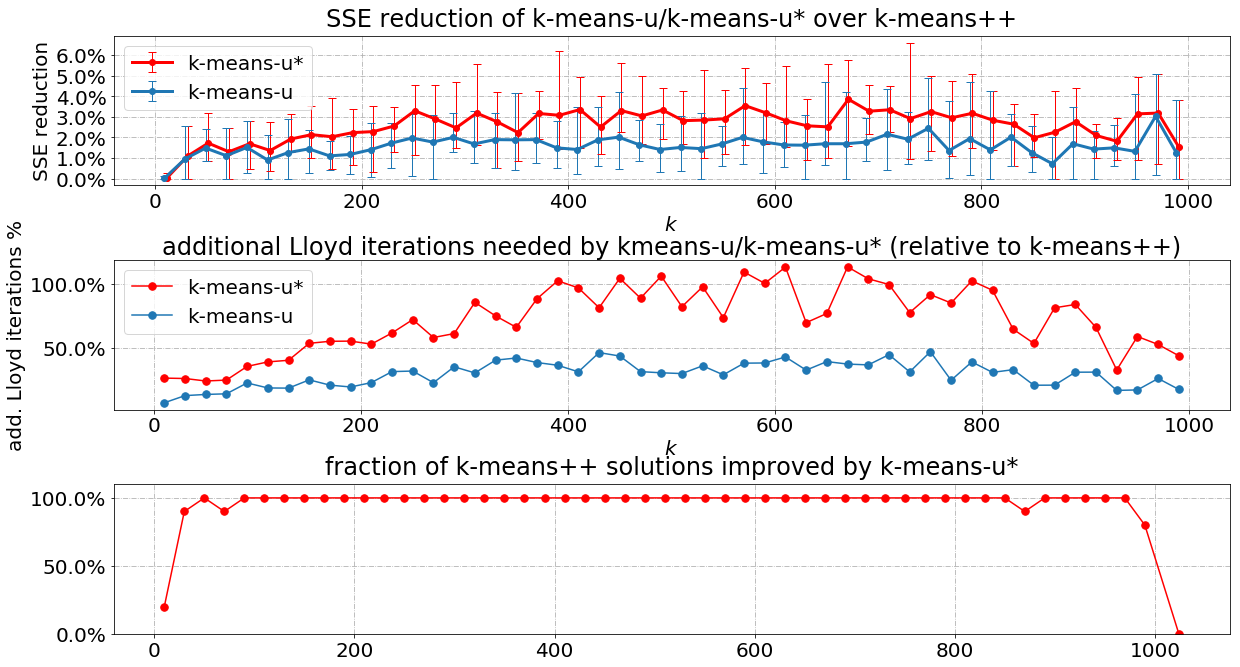

In [26]:
fig3 = statistics(res3, tick_spacing_y1=0.01)
if write:
    fig3.savefig(os.path.join(imgdir,"cloudstat"+suffix+".png"),bbox_inches='tight', dpi=300)

## Propulsion Data Simulation

In [27]:
if simulate:
    X = readPropulsionData()
    if full:
        s = list(range(10,500,20))+list(range(500,1040,20))
    else:
        s = list(range(200,220,10))
    res4=simu(X,sizes=s,runsPerModel=runsPerModel, table=table, maxRetry=2)
else:
    print("reading simulation result from file ......")
    res4=pd.read_pickle(os.path.join(pkldir,"res4_0623.pickle"))    

reading simulation result from file ......


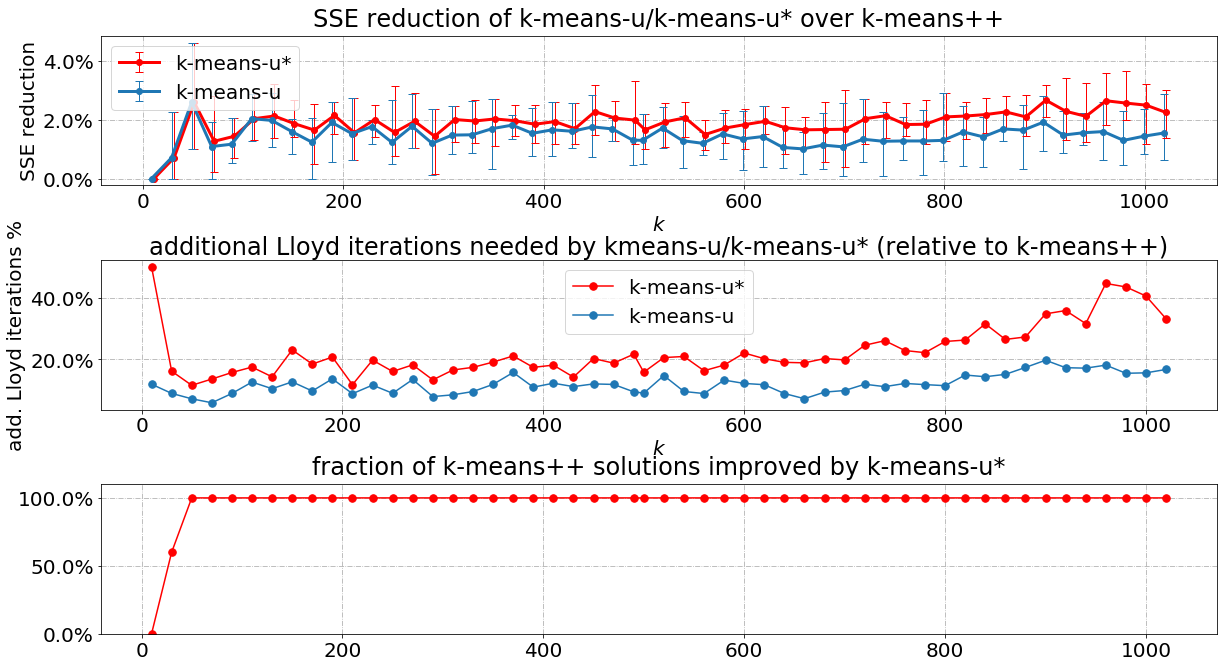

In [28]:
fig4 = statistics(res4)
if write:
    fig4.savefig(os.path.join(imgdir,"propulsionstats"+suffix+".png"),bbox_inches='tight', dpi=300)